In [34]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt
from quantum_logical.basis import RepetitionEncoding
from quantum_logical.basis import QutritPhaseRepetitionCode

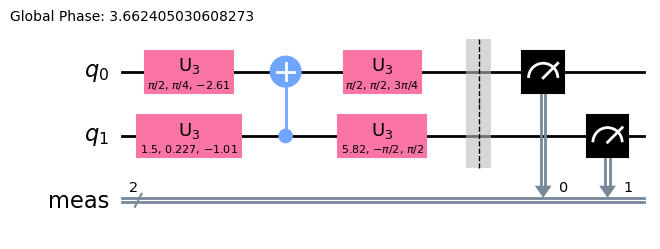

In [35]:
input_circuit = random_circuit(2, 4, seed=42, max_operands=2)
input_circuit = transpile(input_circuit, basis_gates=["u3", "cx"], optimization_level=3)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


In [36]:
# # NOTE: in the expansion pass, we should probably be able to define known rules ahead of time
# # e.g. known translation between logical CNOT and encoded CNOT rather than relying on the
# # mathematical expression which will lead to a harder decomposition problem in the next stage
# from qiskit.transpiler.basepasses import TransformationPass

# class EncodedCircuitExpansionPass(TransformationPass):
#     def __init__(self, encoding):
#         super().__init__()
#         self.encoding = encoding

#     def run(self, dag):

# NOTE: do we want this?
# from quantum_logical.encoded_layout import EncodedLayout
# layout = EncodedLayout()
# layout.add()

In [37]:
# TODO: references
# https://qiskit.org/documentation/stable/0.28/tutorials/noise/6_repetition_code.html
# https://github.com/qiskit-community/qiskit-qec/blob/main/src/qiskit_qec/circuits/repetition_code.py

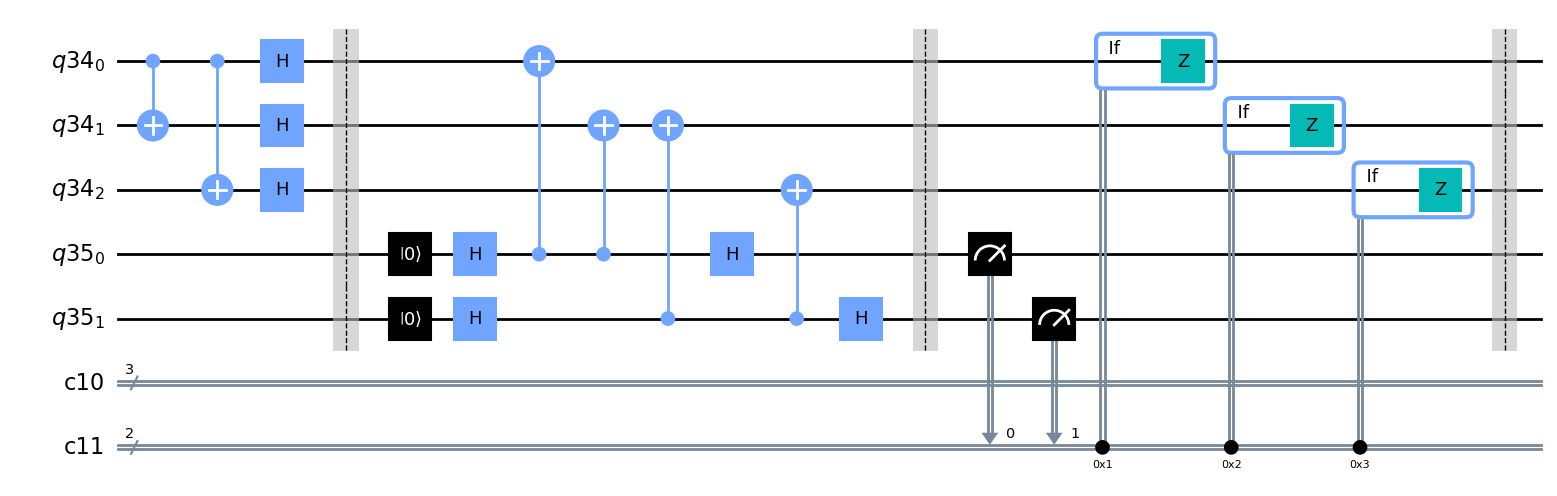

In [38]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding = RepetitionEncoding(phase_flip=True)
qc = encoding.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding.stabilizer_subroutine(qc, qr, ar, car)
# encoding.decoding_circuit(qc, qr)
# qc.barrier()
qc.draw("mpl")

/home/evm9/quantum_logical/src/quantum_logical/qudit_op.py:76: UserWarning: Controlled QutritUnitary class is hardcoded to only be CX_gf gate.
  warnings.warn(


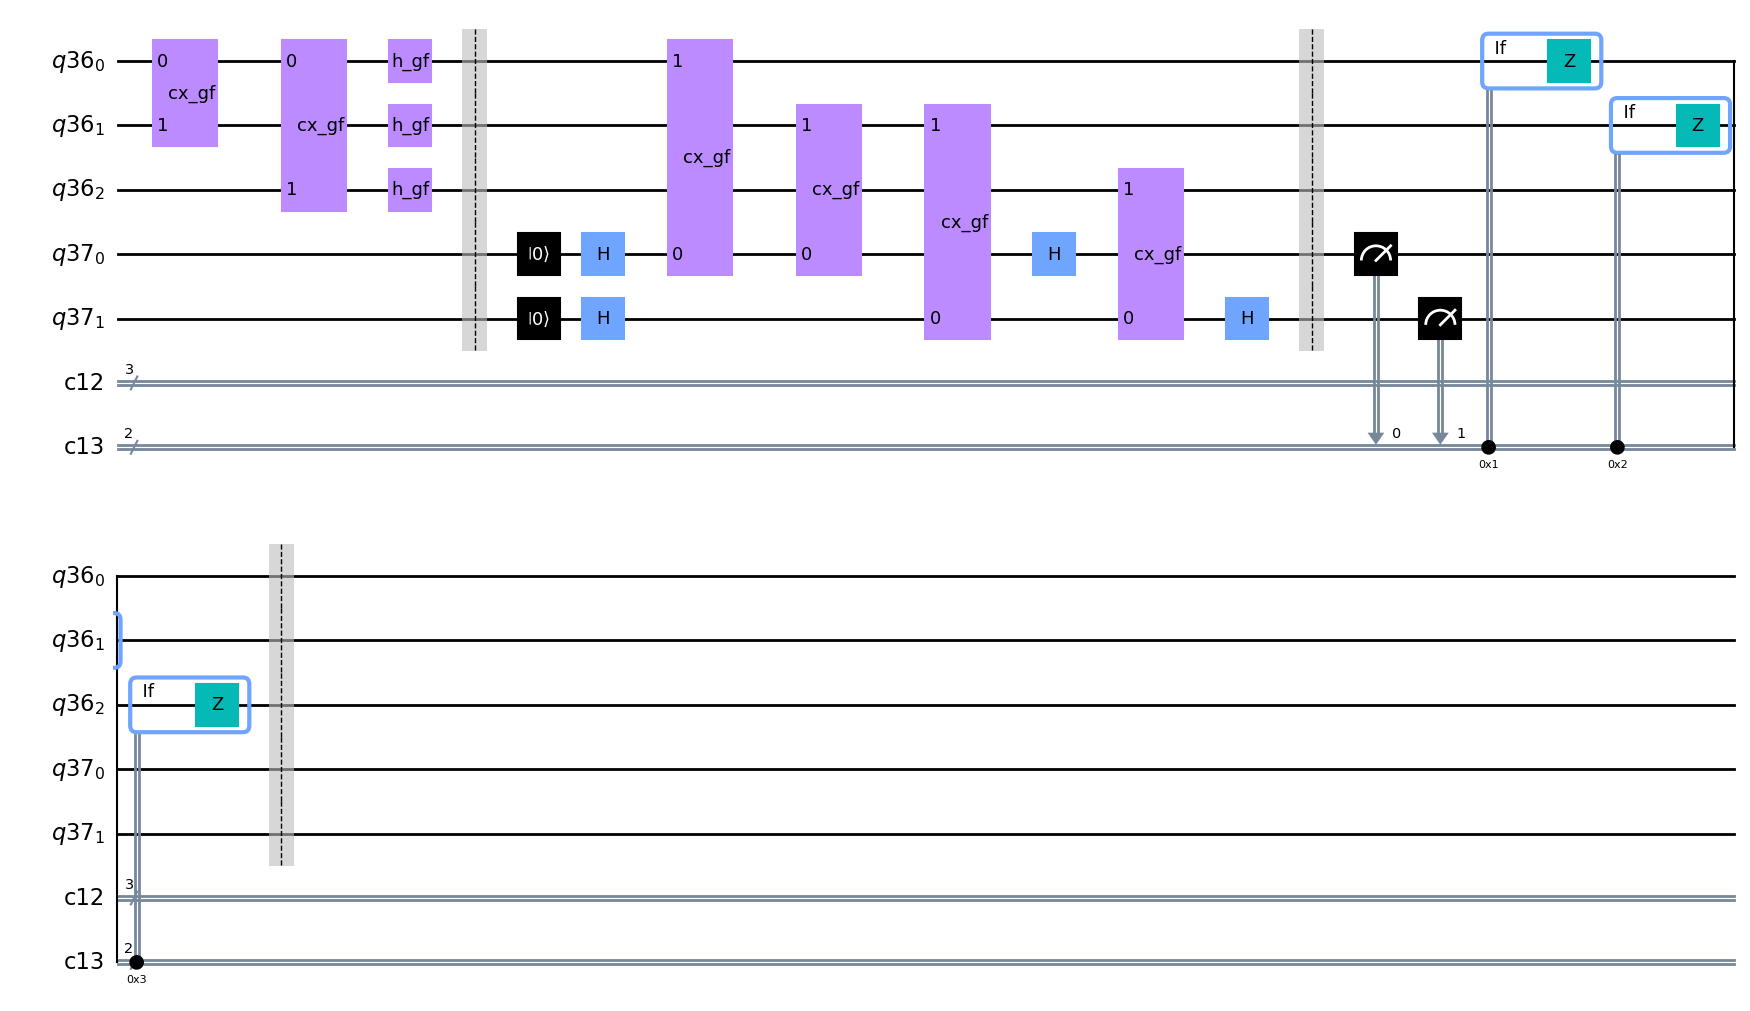

In [39]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding = QutritPhaseRepetitionCode()
qc = encoding.encoding_circuit(qc, qr)
qc.barrier()
qc = encoding.stabilizer_subroutine(qc, qr, ar, car)
qc.draw("mpl")

In [42]:
from qiskit.circuit.library import XGate
from quantum_logical.operators import transform_ge_to_gf_gate

x_gf = transform_ge_to_gf_gate(XGate().to_matrix())
x_gf = QutritUnitary(x_gf, "x_gf")
x_gf.control(1).to_matrix()

/home/evm9/quantum_logical/src/quantum_logical/qudit_op.py:73: UserWarning: Controlled QutritUnitary class is hardcoded to only be CX_gf gate.
  QiskitError: Invalid ctrl_state.


array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j]])